In [1]:
from matplotlib import pyplot
import matplotlib.gridspec as gridspec
from os import listdir
from shapely.geometry import *
import re
from collections import defaultdict as dd
import numpy as np

from figures import SIZE, set_limits, plot_coords, plot_bounds, plot_line_issimple

ModuleNotFoundError: No module named 'figures'

### Helper Methods

In [ ]:
COLOR = {
    True:  '#6699cc',
    False: '#ffcc33'
    }

LINE_COLOR = {
    1:  '#6699cc',
    2: '#ffcc33'
    }

def v_color(ob):
    return COLOR[ob.is_simple]

def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '+', color='#999999', zorder=1)

def plot_bounds(ax, ob):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color='#000000', zorder=1)
    
def plot_start(ax, ob, color):
    ax.plot(ob[0][0], ob[0][1], 'o', color=color, zorder=1)
    
def plot_end(ax, ob, color):
    ax.plot(ob[-1][0], ob[-1][1], 'o', color=color, zorder=1)
    
def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color=v_color(ob), alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    
def plot_radius(ax, pts, radius):
    x = [x[0] for x in pts]
    y = [x[1] for x in pts]

    for i in range(len(x)):
        circle= plt.Circle((x[i],y[i]), radius, fill=False, color='green')
        ax.add_patch(circle)

    
def plot_line2(ax, ob, line_no, linewidth = 2):
    x, y = ob.xy
    ax.plot(x, y, color=LINE_COLOR[line_no], alpha=0.7, linewidth=linewidth, solid_capstyle='round', zorder=2)

### my helper methods

In [2]:
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [3]:
def to_list_of_tuples(linestring):
    #data = 'LINESTRING (9450.877 9108.077, 9682.0 9166.954, 9916.415 9219.2949910.783 7790.984, 9612.096 7797.533, 9180.766 8243.202, 9078.775 8430.877, 8933.664 8636.844, 8995.492 8806.894, 9110.6 8992.445)'
  
    #print (linestring.count('LINESTRING '))
    data = linestring.replace('LINESTRING ', '')[1:-1]
    
    li = data.split(')(')
    #print(li)

    li[0] = li[0].split(',')
    li[1] = li[1].split(',')
   
    list_tuple = []
    
    for i in range(len(li)):
        list_tuple.append([])
        for x in li[i]:
            cord = x.strip().split(' ')
            t =(float(cord[0]), float(cord[1]),)
            list_tuple[i].append(t)

    return list_tuple

### Helper function to find med and min of bus stop interval for each direction

In [4]:
def bus_stop_distances(pts):

    import statistics
    import math
    import numpy as np


   # pts = [(10,10), (10,11), (20,11), (20,10), (10,10)]

    ptdiff = lambda p: (p[0][0]-p[1][0], p[0][1]-p[1][1]) 
    diffs = map (ptdiff , zip(pts[:-1],pts[1:])) 
    path = [math.hypot(d1,d2) for d1,d2 in list(diffs)]
   # print (path)

    med = statistics.median(path)
    mini = min(path)
    mean = np.mean(path)
   # print("Median of data-set is : % s " % (med)) 
   # print("Min of data-set is : % s " % (mini)) 
    
    return {'med': med, 'min':mini, 'mean': mean}

In [5]:
import numpy as np
a = [1,2,2,3,2,1,4,5,5,5,1]
print(np.mean(a), np.average(a))

2.8181818181818183 2.8181818181818183


### Load Routes

In [6]:
routefolder= "ch_routes_2d/"
r = listdir(routefolder)
groups = {}
s_string = ""
linestrings = {}
end1_start2 =dd(list)

for x in r[:]:
    if ".wkt" not in x:
        r.remove(x)
        continue
        
    with open(routefolder + x, 'r') as myfile:
        key = x.replace('.wkt','')
        data=myfile.read().replace('\n', '')
        
        #get end of first direction and start of second 
        #start, end, start2, end2 = ',', ')', ')LINESTRING (', ','
        #end1 = find_between( data, start, end).split(' ')[-2:]
        #start2 = find_between( data, start2, end2).split(' ')
        
        #end1 = [float(x) for x in end1]
        #start2 = [float(x) for x in start2]
        
        #end1_start2[key].extend([tuple(end1),tuple(start2)])
        ls = to_list_of_tuples(data)
        linestrings[key] = ls

FileNotFoundError: [Errno 2] No such file or directory: 'ch_routes_2d/'

Save route distances to json file

In [9]:
import json
def output_distances(linestrings):
    linearRings = {}
    for k,l in linestrings.items():
        l = l[0] + l[1]
        linearRings[k] = LinearRing(l).length
        #linearRings[k]['line'] = l
        #linearRings['distance'] =  LineString(l).length
        
    with open('route_distances.json', 'w') as outfile:
        json.dump(linearRings, outfile, indent=4)

### Plot Routes

In [1]:
cols = 2
rows = (len(linestrings)//cols) + 1
gs = gridspec.GridSpec(rows, cols)

gs.update(hspace=0.4)
# define the data for cartesian plots

distances= []
fig = pyplot.figure(1, figsize = (20, 160), dpi = 180)
ax = []

i = 0

output_distances(linestrings)

for k,l in linestrings.items():
    row = (i // cols)
    col = i % cols
    i += 1

    line1 = LineString(l[0])
    line2 = LineString(l[1])
    line = LinearRing(l[0] +l[1])
    #print(line.length)
    #line = line.simplify(500, preserve_topology=False)

    ax.append(fig.add_subplot(gs[row, col]))
    title = 'Route: {0} \n Distance: {1} Km'.format(k, int(line1.length + line2.length)/1000)
    ax[-1].set_title(title)
    #ax[-1].set_aspect(1)
    
    distances.append(line1.length + line2.length)

    plot_coords(ax[-1], line1) #Important
    plot_coords(ax[-1], line2)
    
    # show radius of avg distance between stops
    #radius0 = bus_stop_distances(l[0])['min']
    #plot_radius(ax[-1], l[0], radius0)
   
    # radius1 = bus_stop_distances(l[1])['min']
   # plot_radius(ax[-1], l[1], radius1)
    
    
    #plot_bounds(ax, line)
    plot_start(ax[-1], l[0], '#202ee9')
    plot_end(ax[-1], l[0], '#e920d8')
    plot_start(ax[-1], l[1], '#00FF00')
    plot_end(ax[-1], l[1], '#FF0000')
    
    
    #plot_line_issimple(ax[-1], line1, alpha=0.7)
    
    plot_line2(ax[-1], line1, 1, linewidth = 2)
    plot_line2(ax[-1], line2, 2, linewidth = 2)
    
    plot_line2(ax[-1], LineString((l[0][-1], l[1][0])), 1)
    plot_line2(ax[-1], LineString((l[1][-1], l[0][0])), 2)
    

pyplot.show()


NameError: name 'linestrings' is not defined

In [14]:
print (np.mean(distances), np.std(distances))

15703.568806761858 7316.063988256744


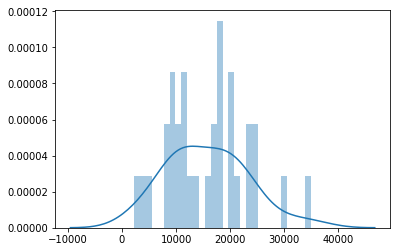

In [16]:
import seaborn as sns
sns.distplot(distances, kde=True, bins=30)